[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pablo-sampaio/rl_facil/blob/main/cap07/cap07-main.ipynb)

# Capítulo 7 - Algoritmos com Modelo


## Configurações Iniciais

In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg

    !pip install gymnasium moviepy
    !pip install optuna

    # clone repository
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")

else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

clear_output()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Cloning into 'rl_facil'...
remote: Enumerating objects: 1706, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 1706 (delta 208), reused 204 (delta 102), pack-reused 1370 (from 1)
Receiving objects: 100% (1706/1706), 30.27 MiB | 37.79 MiB/s, done.
Resolving deltas: 100% (1131/1131), done.


In [2]:
import random as rand
import gymnasium as gym
import numpy as np

from util.experiments import repeated_exec
from util.plot import plot_result, plot_multiple_results
from util.notebook import display_videos_from_path

from util.qtable_helper import evaluate_qtable, record_video_qtable

In [3]:
# basta importar o módulo que o ambiente "RaceTrack-v0" é registrado no gym
import envs

## 1 - Q-Learning

O *Q-Learning* é um algoritmo **livre de modelo**, que vamos comparar com o próximo algoritmo, chamado *Dyna-Q* que é um algoritmo **com modelo**.

Recomendamos acessar  o **código** do Q-Learning no `cap05/qlearning_sarsa.py` para relembrar.

Também vamos executar o Q-Learning, logo abaixo, para comparar com o desempenho do próximo algoritmo.

In [4]:
from cap05.qlearning_sarsa import run_qlearning

In [5]:
# escolha o ambiente descomentando uma das linhas abaixo
#ENV_NAME = "Taxi-v3"
ENV_NAME = "RaceTrack-v0"

LR = 0.3
GAMMA = 0.90
EPSILON = 0.1

#VERBOSE = True

In [6]:
env = gym.make(ENV_NAME)

if ENV_NAME == "Taxi-v3":
    rmax = 10.0
    EPISODES = 700
else:
    rmax = 0.0
    EPISODES = 3_000

rewards1, qtable1 = run_qlearning(env, EPISODES, LR, GAMMA, EPSILON)
print("Últimos resultados: media =", np.mean(rewards1[-20:]), ", desvio padrao =", np.std(rewards1[-20:]))

Últimos resultados: media = -60.65 , desvio padrao = 57.47806103201464


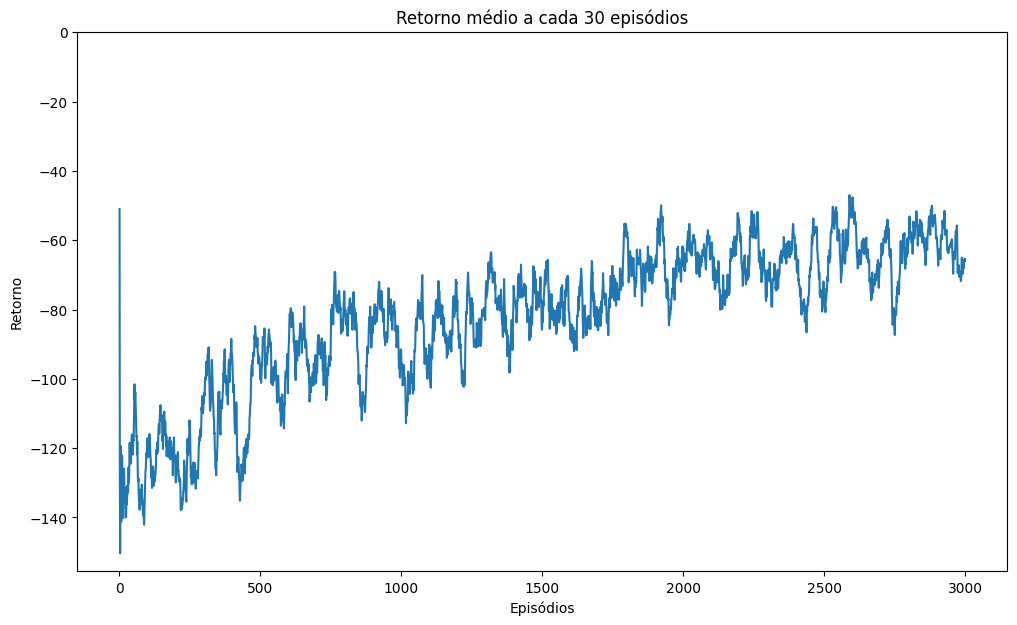

In [7]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards1, rmax, cumulative=False, window=30)

In [8]:
evaluate_qtable(env, qtable1, 10, verbose=True);

Episódio 1: -200.0
Episódio 2: -200.0
Episódio 3: -200.0
Episódio 4: -200.0
Episódio 5: -200.0
Episódio 6: -200.0
Episódio 7: -200.0
Episódio 8: -200.0
Episódio 9: -200.0
Episódio 10: -200.0
Retorno médio (por episódio): -200.00, episódios: 10, total de passos: 2000


In [9]:
record_video_qtable(ENV_NAME, qtable1, episodes=3, folder='./videos-qlearn')

In [10]:
display_videos_from_path('./videos-qlearn', speed=0.5)

## 2 - Dyna-Q

O *Dyna-Q* é um algoritmo **com modelo** que é uma extensão do *Q-Learning*. Compare os códigos para entender o Dyna-Q.

In [11]:
def planning(model, planning_steps, Q, lr, gamma):
    all_s_a = list(model.keys())
    if len(all_s_a) < planning_steps:
        samples = rand.choices(all_s_a, k=planning_steps)
    else:
        samples = rand.sample(all_s_a, k=planning_steps)

    for s, a in samples:
        r, next_s, is_terminal = model[(s,a)]
        if is_terminal:
            V_next_s = 0
        else:
            V_next_s = np.max(Q[next_s])
        delta = (r + gamma * V_next_s) - Q[s,a]
        Q[s,a] = Q[s,a] + lr * delta

In [12]:
# Esta é a política. Neste caso, escolhe uma ação com base nos valores da tabela Q, usando uma estratégia epsilon-greedy,
# dividindo a probabilidade igualmente em caso de empates entre ações de valor máximo.
from util.qtable_helper import epsilon_greedy

In [13]:
# Algoritmo Dyna Q
def run_dyna_q(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, planning_steps=5, verbose=False):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

    # inicializa a tabela Q
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))

    model = dict({})

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table / direct RL
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            # atualiza o modelo
            model[state,action] = (reward, next_state, terminated)

            # planejamento / indirect RL
            planning(model, planning_steps, Q, lr, gamma)

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

        # a cada 100 episódios, imprime informação sobre o progresso
        if verbose and ((i+1) % 100 == 0):
            avg_reward = np.mean(sum_rewards_per_ep[-100:])
            print(f"Episode {i+1} Average Reward (last 100): {avg_reward:.3f}")

    state = env.reset()
    reward = 0

    return sum_rewards_per_ep, Q

In [14]:
env = gym.make(ENV_NAME)

if ENV_NAME == 'Taxi-v3':
    rmax = 10.0
    EPISODES = 700
else:
    rmax = 0.0
    EPISODES = 3_000

rewards2, qtable2 = run_dyna_q(env, EPISODES, LR, GAMMA, EPSILON, planning_steps=10, verbose=True)
print("Últimos resultados: media =", np.mean(rewards2[-20:]), ", desvio padrao =", np.std(rewards2[-20:]))

Episode 100 Average Reward (last 100): -120.850
Episode 200 Average Reward (last 100): -116.300
Episode 300 Average Reward (last 100): -98.940
Episode 400 Average Reward (last 100): -87.830
Episode 500 Average Reward (last 100): -81.240
Episode 600 Average Reward (last 100): -72.090
Episode 700 Average Reward (last 100): -78.750
Episode 800 Average Reward (last 100): -70.660
Episode 900 Average Reward (last 100): -63.560
Episode 1000 Average Reward (last 100): -41.670
Episode 1100 Average Reward (last 100): -46.480
Episode 1200 Average Reward (last 100): -40.500
Episode 1300 Average Reward (last 100): -34.850
Episode 1400 Average Reward (last 100): -35.270
Episode 1500 Average Reward (last 100): -31.480
Episode 1600 Average Reward (last 100): -32.920
Episode 1700 Average Reward (last 100): -31.940
Episode 1800 Average Reward (last 100): -29.460
Episode 1900 Average Reward (last 100): -29.650
Episode 2000 Average Reward (last 100): -28.260
Episode 2100 Average Reward (last 100): -26.520

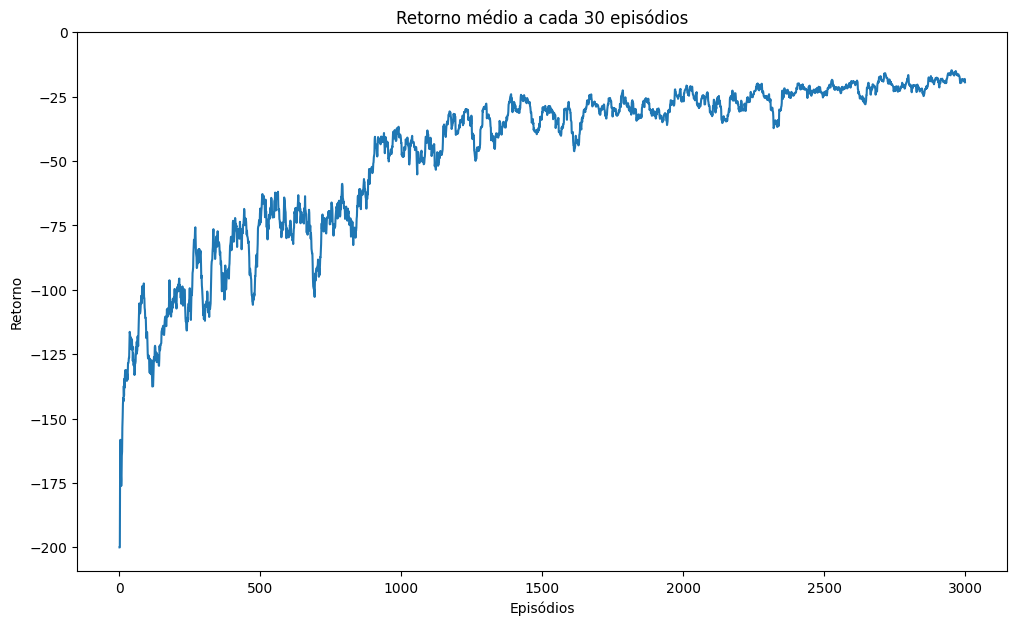

In [15]:
# Mostra um gráfico de passos x retornos não descontados acumulados
plot_result(rewards2, rmax, cumulative='no', window=30)

In [16]:
evaluate_qtable(env, qtable2, 10, verbose=True);

Episódio 1: -18.0
Episódio 2: -18.0
Episódio 3: -25.0
Episódio 4: -22.0
Episódio 5: -22.0
Episódio 6: -9.0
Episódio 7: -9.0
Episódio 8: -25.0
Episódio 9: -18.0
Episódio 10: -18.0
Retorno médio (por episódio): -18.40, episódios: 10, total de passos: 194


In [17]:
record_video_qtable(ENV_NAME, qtable2, episodes=3, folder='./videos-dynaq')

In [18]:
display_videos_from_path("./videos-dynaq", speed=0.5)

## 3 - Experimentos Q-Learning x Dyna-Q

Nesta seção, você pode fazer experimentos no `Taxi-v3` ou no `RaceTrack-v0`, como preferir. (Porém, com o `RaceTrack` é mais demorado).

Escolha o ambiente na célula de código abaixo.

Os experimentos têm duas partes:
- Na seção 3.1, vamos otimizar os parâmetros do Q-Learning
- Na seção 3.2, vamos rodar o Q-Learning e o Dyna-Q (ambos com os parâmetros do Q-Learning), para comparar


In [19]:
# Escolha abaixo o ambiente
ENV_NAME_EXPERIMENT = "RaceTrack-v0"
#ENV_NAME_EXPERIMENT1 = "Taxi-v3"

### 3.1 - Otimizando Parâmetros do Q-Learning

In [20]:
import optuna

Veja o script `cap07/optimize_params.py`, que faz uma otimização usando o `optuna`.

A linha abaixo executa o script como um comando externo.

In [25]:
if IN_COLAB:
    !python rl_facil/cap07/optimize_params.py --env {ENV_NAME_EXPERIMENT}
else:
    !python -m optimize_params --env {ENV_NAME_EXPERIMENT}

#clear_output()

[I 2024-12-17 10:19:20,272] Using an existing study with name 'qlearning_RaceTrack-v0' instead of creating a new one.

TRIAL #7: lr=0.9877578074319454, eps=0.1784509980333023, gamma=0.8853390183399306
Executing <function run_qlearning at 0x7a26cbc2e830>:
  0% 0/3 [00:00<?, ?it/s]
TRIAL #6: lr=0.3254008161389683, eps=0.098323433596541, gamma=0.8815924897457789
Executing <function run_qlearning at 0x7a26cbc2e830>:

 33% 1/3 [00:03<00:06,  3.40s/it]
 67% 2/3 [00:08<00:04,  4.16s/it]
100% 3/3 [00:12<00:00,  4.18s/it]
  (3 executions of qlearn-optuna finished in 12.55 secs)
[I 2024-12-17 10:19:35,696] Trial 7 finished with value: -11597.0 and parameters: {'lr': 0.9877578074319454, 'epsilon': 0.1784509980333023, 'gamma': 0.8853390183399306}. Best is trial 4 with value: -11226.0.

100% 3/3 [00:14<00:00,  4.86s/it]
  (3 executions of qlearn-optuna finished in 14.65 secs)

TRIAL #8: lr=0.2916581056499354, eps=0.1812880030551594, gamma=0.8359392443796856
Executing <function run_qlearning at 0x7a

Depois, carregue os resultados com o comando abaixo:

In [27]:
study = optuna.load_study(storage=f"sqlite:///optuna_cap07.db",
                          study_name=f"qlearning_{ENV_NAME_EXPERIMENT}")

print(f"MELHORES PARÂMETROS PARA {ENV_NAME_EXPERIMENT}:")
print(study.best_params)

qlearn_params_t = study.best_params

MELHORES PARÂMETROS PARA RaceTrack-v0:
{'lr': 0.9890603952051107, 'epsilon': 0.07811907444969937, 'gamma': 0.9762248793176082}


Se não quiser rodar a otimização, você pode descomentar uma das linhas abaixo.

In [ ]:
# para o Racetrack
#qlearn_params_t = {'lr': 0.7713438506137502, 'epsilon': 0.11226178281256971, 'gamma': 0.9849759114245229}

# para o Taxi
#qlearn_params_t = {'lr': 0.9159141726489135, 'epsilon': 0.025509143159405598, 'gamma': 0.7577721224627403}

### 3.2 - Experimentos Comparativos

In [ ]:
environment = gym.make(ENV_NAME_EXPERIMENT)

if ENV_NAME_EXPERIMENT == "Taxi-v3":
    EPISODES = 1_000
else:
    EPISODES = 4_000

RUNS = 5
AUTO_LOAD = True

results_t = []

results_t.append( repeated_exec(RUNS, f"Q-Learning ", run_qlearning, environment, EPISODES, **qlearn_params_t, auto_load=AUTO_LOAD) )
clear_output()

#plan_steps = 1
#results_t.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passo)", run_dyna_q, environment, EPISODES, **qlearn_params_taxi, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
#clear_output()

plan_steps = 10
results_t.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passos)", run_dyna_q, environment, EPISODES, **qlearn_params_t, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
clear_output()


Executing <function run_dyna_q at 0x789243775bd0>:


 60%|██████    | 3/5 [03:46<02:31, 75.64s/it]

In [ ]:
plot_multiple_results(results_t, cumulative='no', x_log_scale=False, window=100)

In [ ]:
plot_multiple_results(results_t, cumulative='avg', x_log_scale=False)

## 4 - Experimentos com "FrozenLake-v1"

Nesta seção, vamos fazer experimentos similares aos da seção 3, mas focando no ambiente `FrozenLake`.

Este ambiente tem como diferencial o fato de ser **não-determinístico**:
- uma ação tem 1/3 de chance de dar o resultado correto
- e 1/3 de fazer o agente mover em cada direção perpendicular à desejada.

Isso afeta um pouco os resultados, como veremos.

In [ ]:
#ENV_NAME_EXPERIMENT2 = "FrozenLake-v1"

Novamente, vamos usar o script `cap07/optimize_params` para otimizar o Q-Learning no `FrozenLake-v1`.

In [ ]:
if IN_COLAB:
    !python rl_facil/cap07/optimize_params.py --env FrozenLake-v1
else:
    !python optimize_params.py --env FrozenLake-v1

clear_output()

In [ ]:
# Carrega parâmetros ótimos obtidos com o Optuna
study = optuna.load_study(storage="sqlite:///optuna_cap07.db",
                          study_name=f"qlearning_FrozenLake-v1")

print(f"MELHORES PARÂMETROS PARA FronzenLake-v1:")
print(study.best_params)

qlearn_params_f = study.best_params

Ou descomente a linha abaixo, para rodar com bons parâmetros previamente obtidos com o `optuna`.

In [ ]:
#qlearn_params_f = {'lr': 0.22751008394057, 'epsilon': 0.07783149989309379, 'gamma': 0.9763490337420356}

### 4.1 - Usando Dyna-Q sem alteração

In [ ]:
environment = gym.make("FrozenLake-v1")
EPISODES = 5_000
RUNS = 15
AUTO_LOAD = True

results_f = []

results_f.append( repeated_exec(RUNS, f"Q-Learning ", run_qlearning, environment, EPISODES, **qlearn_params_f, auto_load=AUTO_LOAD) )
clear_output()

#plan_steps = 1
#results_f.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passos)", run_dyna_q, environment, EPISODES, **qlearn_params_f, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
#clear_output()

plan_steps = 5
results_f.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passos)", run_dyna_q, environment, EPISODES, **qlearn_params_f, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
clear_output()

In [ ]:
plot_multiple_results(results_f, cumulative='no', x_log_scale=False, window=100)

In [ ]:
#plot_multiple_results(results_f, cumulative='avg', x_log_scale=False)

Analisando os resultados, o Dyna-Q foi bem no ambiente `FrozenLake-v1`?

Apesar de variar entre execuções, ele não costuma ir bem com quantidades altas de "passos de planejamento" neste ambiente.

**O que explica isso?**

### 4.2 - Desafio

Proponha uma modificação simples no **modelo** e no **planejamento** do *Dyna-Q* para melhorar o desempenho dele no `FrozenLake`.

Depois, refaça os experimentos da seção 4.2 para conferir se deu certo. (O desempenho deve ser melhor do que o do *Dyna-Q* original, pelo menos.)

In [ ]:
def planning_new(model, planning_steps, Q, lr, gamma):
    pass
    # TODO: PROPONHA UMA ALTERAÇÃO AQUI

raise NotImplementedError("Implemente a função planning_new acima antes de prosseguir")

In [ ]:
# Algoritmo Dyna Q
def run_dyna_q_new(env, episodes, lr=0.1, gamma=0.95, epsilon=0.1, planning_steps=5):
    assert isinstance(env.observation_space, gym.spaces.Discrete)
    assert isinstance(env.action_space, gym.spaces.Discrete)

    num_actions = env.action_space.n

   # inicializa a tabela Q
    Q = np.random.uniform(low=-0.01, high=+0.01, size=(env.observation_space.n, num_actions))

    model = dict({})

    # para cada episódio, guarda sua soma de recompensas (retorno não-descontado)
    sum_rewards_per_ep = []

    # loop principal
    for i in range(episodes):
        done = False
        sum_rewards, reward = 0, 0

        state, _ = env.reset()

        # executa 1 episódio completo, fazendo atualizações na Q-table
        while not done:

            # escolhe a próxima ação -- usa epsilon-greedy
            action = epsilon_greedy(Q, state, epsilon)

            # realiza a ação, ou seja, dá um passo no ambiente
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                # para estados terminais
                V_next_state = 0
            else:
                # para estados não-terminais -- valor máximo (melhor ação)
                V_next_state = np.max(Q[next_state])

            # atualiza a Q-table / direct RL
            delta = (reward + gamma * V_next_state) - Q[state,action]
            Q[state,action] = Q[state,action] + lr * delta

            # atualiza o modelo
            # TODO: PROPONHA UMA ALTERAÇÃO AQUI

            # planejamento / indirect RL
            planning_new(model, planning_steps, Q, lr, gamma)

            sum_rewards += reward
            state = next_state

        sum_rewards_per_ep.append(sum_rewards)

    state = env.reset()
    reward = 0

    return sum_rewards_per_ep, Q

In [ ]:
environment = gym.make("FrozenLake-v1")
EPISODES = 5_000
RUNS = 15
AUTO_LOAD = True

results_f2 = []

results_f2.append( repeated_exec(RUNS, f"Q-Learning ", run_qlearning, environment, EPISODES, **qlearn_params_f, auto_load=AUTO_LOAD) )
clear_output()

plan_steps = 5
results_f2.append( repeated_exec(RUNS, f"Dyna-Q ({plan_steps} passos)", run_dyna_q, environment, EPISODES, **qlearn_params_f, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
clear_output()

plan_steps = 5
results_f2.append( repeated_exec(RUNS, f"Dyna-Q-new ({plan_steps} passos)", run_dyna_q_new, environment, EPISODES, **qlearn_params_f, planning_steps=plan_steps, auto_load=AUTO_LOAD) )
clear_output()

In [ ]:
plot_multiple_results(results_f2, cumulative='no', x_log_scale=False, window=100)